# Install detectron2

In [1]:
### it may be necessary to restart the kernel after installation (for whatever reason)
import sys
!{sys.executable} -m pip install --upgrade pip
import torch, torchvision
if torch.version.cuda == '10.0.130':
    !{sys.executable} -m pip install --upgrade pip
    !{sys.executable} -m pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
    !{sys.executable} -m pip install cython pyyaml==5.1
    !{sys.executable} -m pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
    !{sys.executable} -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
elif torch.version.cuda == '10.1':
    !{sys.executable} -m pip install cython 
    !{sys.executable} -m pip install pyyaml
    !{sys.executable} -m pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
    !{sys.executable} -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
else:
    print(torch.version.cuda)

Requirement already up-to-date: pip in /opt/conda/envs/DLM_Py3/lib/python3.7/site-packages (20.0.2)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-9e4wamye
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-9e4wamye
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=279417 sha256=10676ece85767e890e68e953c347076b7c26b3966e69c7b3537a4439132ca9f2
  Stored in directory: /tmp/pip-ephem-wheel-cache-upz9b31j/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
     |████████████████████████████████| 6.1 MB 833 kB/s eta 0:00:01     |████████████▋                   | 2.4 MB 277 kB/s eta 0:00:14


  Created wheel for fvcore: filename=fvcore-0.1.dev200410-py3-none-any.whl size=38761 sha256=c527e433c9fbf5eefce066a4570d55b0143eae34bf780dc84eac814c289cd5e7
  Stored in directory: /home/Deep_Learner/.cache/pip/wheels/ce/15/df/7532f3b73faae8336444b5183a230ee2e5eca66231d4aa6624
Successfully built fvcore


# Imports

In [12]:
#import sys
#sys.path.append('/opt/conda/lib/python3.7/site-packages')
#sys.path.append('/opt/conda/envs/DLM_R2Py/lib/python3.7/site-packages')

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

%reload_ext autoreload
%autoreload 2
import sys
#!{sys.executable} -m pip install --upgrade matplotlib
#%matplotlib notebook
%matplotlib inline

from typing import Dict, List, Callable


sys.path.append('../preprocessing_pipeline/python-wsi-preprocessing/')
import wsi
from wsi import tiles, util

from bokeh.io import output_notebook

import os
import pandas
import pandas as pd
import numpy
import numpy as np
import torch, torchvision
import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]

import PIL
from PIL import Image

import fastai
from fastai import vision
import matplotlib.pyplot as plt
import matplotlib.patches
import pycocotools
#from pycocotools import mask
from itertools import groupby
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import random
import scipy.io
import json

#Base path to datasets
PATH = Path('/home/Deep_Learner/private/datasets/nuclei_datasets/')

#data science bowl 2018 dataset
DSB_2018 = PATH/'2018_Data_Science_Bowl'
DSB_2018_STAGE1_TRAIN = DSB_2018/'stage1_train'
DSB_2018_STAGE1_TEST = DSB_2018/'stage1_test'
DSB_2018_STAGE1_TRAIN_LABELS = DSB_2018/'stage1_train_labels.csv'
DSB_2018_STAGE1_TEST_LABELS = DSB_2018/'stage1_solution.csv'
DSB_2018_STAGE2_TEST = DSB_2018/'stage2_test_final'
DSB_2018_STAGE2_TEST_SAMPLE_SUBMISSION = DSB_2018/'stage2_sample_submission_final.csv'

### MoNuSeg 2018
MONUSEG_2018 = PATH/'MONUSEG_2018'
MONUSEG_2018_TRAIN = MONUSEG_2018/'MoNuSeg_2018_Training_data'
MONUSEG_2018_TEST = MONUSEG_2018/'MoNuSegTestData'

### PanNuke dataset
PANNUKE = PATH/'PanNuke_dataset'

### CoNSeP dataset
CONSEP = PATH/'CoNSeP'
CONSEP_IMAGES = CONSEP/'Images'
CONSEP_LABELS = CONSEP/'Labels'





dataset_name_train = 'nuclei_train'
dataset_name_valid = 'nuclei_valid'
dataset_name_test = 'nuclei_test'


seed = 19
np.random.seed(seed)

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import ColorMode

# util functions

In [10]:
def save_as_json(dataset_dict, path):
    with open(path, 'w') as outfile:
        json.dump(dataset_dict, outfile)

def load_json(path)->List[Dict]:
    with open(path) as json_file:
        #return json.loads(json.load(json_file))
        return json.load(json_file)

### old
#def visualize(dataset_dicts:List[Dict],
#              metadata:detectron2.data.catalog.Metadata,
#              ground_truth_available:bool,
#              with_preds:bool,
#              predictor, 
#              extract_otf_from_wsi:bool=False):
#    for d in dataset_dicts:
#        imgs_to_show = []
#        
#        path = d['file_name']
#        print(Path(path).name)
#        
#        ### original image
#        img = None
#        if not extract_otf_from_wsi:
#            img = cv2.imread(str(path))
#        else:
#            img = cv2.cvtColor(numpy.array(open_image_custom(fn=path)), cv2.COLOR_RGB2BGR)            
#        imgs_to_show.append(img)
#        
#        ### prediction
#        if with_preds:
#            pred = predictor(img)
#            n_predicted = len(pred['instances'])
#            print(f'number of predicted instances: {n_predicted}')
#            v = Visualizer(img[:, :, ::-1],
#                            metadata=metadata, 
#                            scale=1, 
#                            instance_mode=ColorMode.IMAGE)
#            img_with_preds = v.draw_instance_predictions(pred["instances"].to("cpu")).get_image()[:, :, ::-1]
#            imgs_to_show.append(img_with_preds)
#        
#        ### ground truth
#        if ground_truth_available:
#            ### image with ground truth boxes and masks   
#            visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1)
#            img_with_ground_truth = visualizer.draw_dataset_dict(d).get_image()[:, :, ::-1]
#            imgs_to_show.append(img_with_ground_truth)
#            ### merged masks of the ground truth
#            masks = None
#            try:
#                masks = [open_mask_as_np(mp) for mp in get_masks_path_from_id(path.stem, base_path=path.parent.parent.parent).ls()]    
#            except FileNotFoundError:
#                masks = get_mask_list_from_rle_for_one_id(path.stem, df_rle_labels, shape=(d['width'],d['height']))
#            n_actual = d['annotations']
#            print(f'number of actual instances: {len(n_actual)}')
#            print(f'number of actual instances: {len(masks)}')
#            merged_mask_ground_truth = merge_masks(masks, shape=(masks[0].shape[0], masks[0].shape[1]))
#            imgs_to_show.append(merged_mask_ground_truth)
#            
#            
#        ### plot    
#        f, axarr = plt.subplots(1,len(imgs_to_show), figsize=(20,20))
#        for n, i in enumerate(imgs_to_show):
#            if len(i.shape) == 2:
#                axarr[n].imshow(i)
#            else:
#                axarr[n].imshow(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))            
#        plt.show() 

### new
def visualize(dataset_dicts:List[Dict],
              metadata:detectron2.data.catalog.Metadata,
              ground_truth_available:bool,
              with_preds:bool,
              predictor, 
              extract_otf_from_wsi:bool=False, 
              df_extraction_otf:pandas.DataFrame=None):
    for d in dataset_dicts:
        imgs_to_show = []
        
        path = d['file_name']
        print(Path(path).name)
        
        ### original image
        img = None
        if not extract_otf_from_wsi:
            ###some of the images are in rgba format, [:,:,:3] drops the alpha
            img = numpy.array(PIL.Image.open(path))[:,:,:3]
        else:
            img = numpy.array(open_image_from_wsi(fn=path, tiles_df=df_extraction_otf))           
        imgs_to_show.append(img)
        
        ### instantiate Visualizer
        v = Visualizer(img,
                       metadata=metadata, 
                       scale=1, 
                       instance_mode=ColorMode.IMAGE)
        
        ### prediction
        if with_preds:
            pred = predictor(img[:, :, ::-1])
            n_predicted = len(pred['instances'])
            print(f'number of predicted instances: {n_predicted}')
            img_with_preds = v.draw_instance_predictions(pred["instances"].to("cpu")).get_image()
            imgs_to_show.append(img_with_preds)
        
        ### ground truth
        if ground_truth_available:
            ### image with ground truth boxes and masks   
            img_with_ground_truth = v.draw_dataset_dict(d).get_image()
            imgs_to_show.append(img_with_ground_truth)
            ### merged masks of the ground truth
            masks = None
            try:
                masks = [open_mask_as_np(mp) for mp in get_masks_path_from_id(path.stem, base_path=path.parent.parent.parent).ls()]    
            except FileNotFoundError:
                masks = get_mask_list_from_rle_for_one_id(path.stem, df_rle_labels, shape=(d['width'],d['height']))
            n_actual = d['annotations']
            print(f'number of actual instances: {len(n_actual)}')
            print(f'number of actual instances: {len(masks)}')
            merged_mask_ground_truth = merge_masks(masks, shape=(masks[0].shape[0], masks[0].shape[1]))
            imgs_to_show.append(merged_mask_ground_truth)
            
            
        ### plot    
        f, axarr = plt.subplots(1,len(imgs_to_show), figsize=(20,20))
        for n, i in enumerate(imgs_to_show):
            if len(i.shape) == 2:
                axarr[n].imshow(i)
            else:
                axarr[n].imshow(i)            
        plt.show() 

def show_np(arr:numpy.ndarray):
    plt.imshow(arr)
    plt.show()
    
from matplotlib.pyplot import imshow
def show_pil(path:pathlib.Path):    
    imshow(np.asarray(Image.open(path)))
    plt.show()

def get_path_from_id(img_id:str, base_path:pathlib.Path)->pathlib.Path:
    """
    Arguments:
        base_path: here ~/2018_Data_Science_Bowl/stage1_train/   or   ~/2018_Data_Science_Bowl/stage1_test/
    """
    for p in base_path.ls():
        if img_id in p.stem:
            return p

def get_masks_path_from_id(img_id:str, base_path:pathlib.Path)->pathlib.Path:
    """
    Arguments:
        base_path: here ~/2018_Data_Science_Bowl/stage1_train/   or   ~/2018_Data_Science_Bowl/stage1_test/
    """
    return get_path_from_id(img_id, base_path)/'masks'
        
def open_mask_as_np(path:pathlib.Path)->numpy.ndarray:
    return np.asarray(PIL.Image.open(path), dtype=np.bool)

def show_np_with_bboxes(img:numpy.ndarray, bboxes:List[numpy.ndarray]):
    """
    Arguments:
        img: img as numpy array
        bboxes: List of bounding boxes where each bbox is a numpy array: 
                array([ x-upper-left, y-upper-left,  width,  height]) 
                e.g. array([ 50., 211.,  17.,  19.])
    """    
    # Create figure and axes
    fig,ax = plt.subplots(1)    
    # Display the image
    ax.imshow(img)    
    # Create a Rectangle patch for each bbox
    for b in bboxes:
        rect = matplotlib.patches.Rectangle((b[0],b[1]),b[2],b[3],linewidth=1,edgecolor='r',facecolor='none')    
        # Add the patch to the Axes
        ax.add_patch(rect)    
    plt.show()    

def merge_masks(masks:List[numpy.ndarray], shape:tuple=(256,256))->numpy.ndarray:
    merged_mask = np.zeros((shape[0],shape[1]), dtype=np.bool)
    for mask in masks:
        merged_mask = np.maximum(merged_mask, mask)
    return merged_mask

def merge_masks_from_path(path:pathlib.Path, shape:tuple=(256,256))->numpy.ndarray:
    return merge_masks([open_mask_as_np(p) for p in path.ls()], shape)


def rle_encode(mask_np:numpy.ndarray)->List[int]:
    '''
    mask_np: numpy array of shape (height, width), 1 = mask, 0 = background
    Returns run length as list
    '''
    dots = np.where(mask_np.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def rle_from_list_to_string(rle_as_list:List[int])->str:
    return ' '.join([str(e) for e in rle_as_list])

def rle_decode(mask_rle:str, shape:tuple=(256, 256))->numpy.ndarray:
    '''
    Arguments:
        mask_rle: run-length as string formated (start length) e.g. "6908 1 7161 8 7417 8"
        shape: (height,width) of array to return
    Returns: 
        numpy array, True == mask, False == background
    '''
    #print('rle_decode(mask_rle = ', mask_rle)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    mask = np.zeros(shape[0]*shape[1], dtype=np.bool)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = True
    # Needed to align to RLE direction
    return mask.reshape(shape).T

def get_mask_list_from_rle_for_one_id(img_id:str, 
                                      df:pandas.DataFrame, 
                                      coloumn_name_ids:str='ImageId',
                                      coloumn_name_rle:str='EncodedPixels',
                                      shape:tuple=(256,256))->List[numpy.ndarray]:
    """
    Arguments:
        shape: tuple (width, height)
    Returns:
        
    """
    masks_rle_df = df.loc[df[coloumn_name_ids] == img_id]
    masks = []
    for index, row in masks_rle_df.iterrows():
        #print(row[coloumn_name_rle])
        masks.append(rle_decode(row[coloumn_name_rle], shape))
    return masks

def mask_to_bbox(mask_np:numpy.ndarray)->numpy.ndarray:
    """
    Arguments: 
        mask_np: binary mask as numpy array where mask == True or 1 or 1.0 and background == False or 0 or 0.0
    Returns:
        bounding box as numpy array: array([ x-upper-left, y-upper-left,  width,  height]) 
                                        e.g. array([ 50., 211.,  17.,  19.])
    """
    return pycocotools.mask.toBbox(pycocotools.mask.encode(np.asarray(mask_np, order="F")))


def rle_encode_pycoco(mask_np:numpy.ndarray)->dict:
    '''
    Arguments:
        mask_np: numpy array of shape (height, width), 1 = mask, 0 = background
    Returns: 
        dict with size and per-pixel segmentation mask in COCO's RLE format.        
    '''
    #option 1
    return pycocotools.mask.encode(np.asarray(mask, order="F"))
    #option 2
    #rle = {'counts': [], 'size': list(mask_np.shape)}
    #counts = rle.get('counts')
    #for i, (value, elements) in enumerate(groupby(mask_np.ravel(order='F'))):
    #    if i == 0 and value == 1:
    #        counts.append(0)
    #    counts.append(len(list(elements)))
    #return rle

#!{sys.executable} -m pip install imantics
import imantics
from imantics import Polygons, Mask
def get_polygon_from_binary_mask(mask_np:numpy.ndarray)->List[float]:
    """
    Arguments:
        binary mask as numpy array
    Returns:
        list[int] is one simple polygon in the format of [x1, y1, ..., xn, yn]
    """
    return [float(c) for c in list(Mask(mask_np).polygons()[0])]

# some util examples

## load csv

In [ ]:
s1_trn_lbs_df = pd.read_csv(STAGE1_TRAIN_LABELS)

In [ ]:
s1_trn_lbs_df

In [ ]:
img_id = s1_trn_lbs_df.iloc[0][0];img_id

## merge existing single masks of one image - example

In [ ]:
img_id_p = get_path_from_id(img_id, STAGE1_TRAIN)

In [ ]:
masks_path = get_masks_path_from_id(img_id, STAGE1_TRAIN);masks_path

In [ ]:
masks_np = [open_mask_as_np(p) for p in masks_path.ls()]

In [ ]:
merged_mask = merge_masks_from_path(masks_path,(256,256))

In [ ]:
show_np(merged_mask)

## decode run length encoding to mask - example

In [ ]:
masks = get_mask_list_from_rle_for_one_id(img_id, s1_trn_lbs_df)

In [ ]:
merged_mask = merge_masks(masks)

In [ ]:
show_np(merged_mask)

## get bounding box from mask in format x,y (left upper corner); width, heigth - example

In [ ]:
img_id

In [ ]:
img_p = get_path_from_id(img_id, STAGE1_TRAIN);img_p

In [ ]:
masks_p = get_masks_path_from_id(img_id, STAGE1_TRAIN);masks_p

In [ ]:
bboxes = []
for p in masks_p.ls():
    mask_np = open_mask_as_np(p)
    bboxes.append(mask_to_bbox(mask_np))

In [ ]:
merged_mask = merge_masks_from_path(masks_p)

In [ ]:
show_np_with_bboxes(merged_mask,bboxes)

# Data

## Get various datsets into right format for detectron2

### dsb 2018

In [14]:
def get_nuclei_dicts_dsb18(isTestSet:bool=False):
    """
    Arguments:
    """
    dataset_dicts_dsb18_json_filepath = None
    if isTestSet:        
        dataset_dicts_dsb18_json_filepath = Path('./dataset_dicts/dataset_dicts_dsb18_test2.json')
    else:
        dataset_dicts_dsb18_json_filepath = Path('./dataset_dicts/dataset_dicts_dsb18_train+test1.json')
        
    if dataset_dicts_dsb18_json_filepath.exists():
        return load_json(dataset_dicts_dsb18_json_filepath)
    else:        
        img_paths = None
        if isTestSet:
            img_paths = [path/'images'/f'{path.name}.png' for path in DSB_2018_STAGE2_TEST.ls()]
        else:
            excluded_ids = ['7b38c9173ebe69b4c6ba7e703c0c27f39305d9b2910f46405993d2ea7a963b80']
            img_paths = [p/'images'/f'{p.name}.png' for p in DSB_2018_STAGE1_TRAIN.ls()+DSB_2018_STAGE1_TEST.ls() \
                 if p.name not in excluded_ids]
                   
        dataset_dicts = []
        for path in tqdm(img_paths):
            path = Path(path)
            record = {}
    
            img_pil = PIL.Image.open(path)
                
            width = img_pil.width
            height = img_pil.height
            
            record["file_name"] = str(path)
            record["image_id"] = path.stem
            record["height"] = height
            record["width"] = width
            
            
            objs = []
            if not isTestSet:
                df_rle_labels = pd.concat([pd.read_csv(DSB_2018_STAGE1_TRAIN_LABELS), 
                                pd.read_csv(DSB_2018_STAGE1_TEST_LABELS)], 
                                ignore_index=True, sort=False)
                masks = get_mask_list_from_rle_for_one_id(path.stem, df_rle_labels, shape=(width,height))
                                
                for mask in masks:
                    obj = {"bbox": list(mask_to_bbox(mask)),
                            "bbox_mode": BoxMode.XYWH_ABS,
                            "segmentation": [get_polygon_from_binary_mask(mask)],
                            #"segmentation": rle_encode_pycoco(mask),
                            "category_id": 0,
                            "iscrowd": 0}
                    ### detectron2 lib throws AssertionError if not (len(polygon) % 2 == 0 and len(polygon) >= 6)
                    if len(obj["segmentation"][0]) >= 6:
                        objs.append(obj)
                    
            record["annotations"] = objs
            dataset_dicts.append(record)
        save_as_json(dataset_dicts, dataset_dicts_dsb18_json_filepath)
        return dataset_dicts

In [8]:
dataset_dicts_dsb18_train_and_test1 = get_nuclei_dicts_dsb18(isTestSet=False)

In [10]:
dataset_dicts_dsb18_test2 = get_nuclei_dicts_dsb18(isTestSet=True)

### MoNuSeg 2018 (TODO: test set)

In [26]:
def get_nuclei_dicts_monuseg18():
    """
    Arguments:
    """    
    dataset_dicts_monuseg18_json_filepath = Path('./dataset_dicts/dataset_dicts_monuseg18.json')
        
    if dataset_dicts_monuseg18_json_filepath.exists():
        return load_json(dataset_dicts_monuseg18_json_filepath)
    else:        
        img_paths_train = [p/'images'/f'{p.name}.png' for p in MONUSEG_2018_TRAIN.ls()] 
        img_paths_test = [p for p in MONUSEG_2018_TEST.ls() if p.suffix == '.tif']        
        
        dataset_dicts = []
        for path in tqdm(img_paths_train):
            path = Path(path)
            record = {}
    
            img_pil = PIL.Image.open(path)
                
            width = img_pil.width
            height = img_pil.height
            
            record["file_name"] = str(path)
            record["image_id"] = path.stem
            record["height"] = height
            record["width"] = width
                        
            masks = [open_mask_as_np(mp) for mp in get_masks_path_from_id(path.stem, base_path=path.parent.parent.parent).ls()]    
            objs = []                    
            for mask in masks:
                obj = {"bbox": list(mask_to_bbox(mask)),
                        "bbox_mode": BoxMode.XYWH_ABS,
                        "segmentation": [get_polygon_from_binary_mask(mask)],
                        #"segmentation": rle_encode_pycoco(mask),
                        "category_id": 0,
                        "iscrowd": 0}
                ### detectron2 lib throws AssertionError if not (len(polygon) % 2 == 0 and len(polygon) >= 6)
                if len(obj["segmentation"][0]) >= 6:
                    objs.append(obj)
                    
            record["annotations"] = objs
            dataset_dicts.append(record)
            
        #for path in tqdm(img_paths_test):
            ###
            # TODO
            ###
            
        save_as_json(dataset_dicts, dataset_dicts_monuseg18_json_filepath)
        return dataset_dicts

In [27]:
dataset_dicts_monuseg18 = get_nuclei_dicts_monuseg18()

### CoNSeP

In [36]:
def get_nuclei_dicts_consep():
    """
    Arguments:
    """ 
    dataset_dicts_consep_json_filepath = Path('./dataset_dicts/dataset_dicts_consep.json')
    if dataset_dicts_consep_json_filepath.exists():
        return load_json(dataset_dicts_consep_json_filepath)
    else:
        consep_image_paths = CONSEP_IMAGES.ls()
        consep_label_paths = CONSEP_LABELS.ls()
        dataset_dicts = []
        
        for img_path in tqdm(consep_image_paths):
            record = {}
            
            name = img_path.stem
            ### find corresponding .mat label file for image
            label_path = None
            for lbl_path in consep_label_paths:
                if name == lbl_path.stem:
                    label_path = lbl_path
                    break
            ### every instance mask is encoded with a unique number, all in one channel
            masks_combined = scipy.io.loadmat(label_path)['inst_map']
            
            height = masks_combined.shape[0]
            width = masks_combined.shape[1]
                    
            record["file_name"] = str(img_path)
            record["image_id"] = str(img_path)
            record["height"] = height
            record["width"] = width
                   
            masks = [(masks_combined == n).astype(int) for n in range(1, int(np.max(masks_combined))+1)]    
            
            objs = []
            for mask in masks:
                obj = {"bbox": list(mask_to_bbox(mask.astype(np.uint8))),
                        "bbox_mode": BoxMode.XYWH_ABS,
                        "segmentation": [get_polygon_from_binary_mask(mask)],
                        #"segmentation": rle_encode_pycoco(mask),
                        "category_id": 0,
                        "iscrowd": 0}
                ### detectron2 lib throws AssertionError if not (len(polygon) % 2 == 0 and len(polygon) >= 6)
                if len(obj["segmentation"][0]) >= 6:
                    objs.append(obj)
                    
            # free memory, otherwise kernel will die
            masks = None        
            record["annotations"] = objs
            dataset_dicts.append(record)
            
        save_as_json(dataset_dicts, dataset_dicts_consep_json_filepath)    
        return dataset_dicts

In [38]:
dataset_dicts_consep = get_nuclei_dicts_consep()

### Placeholder

### Placeholder

## register datasets

In [5]:
from detectron2.data import DatasetCatalog, MetadataCatalog

DatasetCatalog.clear()

DatasetCatalog.register(dataset_name_train, lambda : get_nuclei_dicts(img_paths_train))
MetadataCatalog.get(dataset_name_train).set(thing_classes=["nucleus"])

DatasetCatalog.register(dataset_name_valid, lambda : get_nuclei_dicts(img_paths_valid))
MetadataCatalog.get(dataset_name_valid).set(thing_classes=["nucleus"])

Metadata(name='nuclei_valid', thing_classes=['nucleus'])

## load datasets

In [ ]:
metadata_nuclei_train = MetadataCatalog.get(dataset_name_train)
dataset_dicts_nuclei_train = get_nuclei_dicts(img_paths_train)

In [6]:
metadata_nuclei_valid = MetadataCatalog.get(dataset_name_valid)
dataset_dicts_nuclei_valid = get_nuclei_dicts(img_paths_valid)

In [ ]:
#for d in dataset_dicts_nuclei:
#    for a in d["annotations"]:
#        polygon = a['segmentation']
#        #print(len(polygon[0]))
#        try:
#            assert len(polygon[0]) % 2 == 0 and len(polygon[0]) >= 6
#        except AssertionError:
#            print(len(polygon[0]))

## sort dataset by number of nuclei and inspect it

In [ ]:
#key: img_path; value: number of nuclei
path_to_n_objects = {}

for ds in [dataset_dicts_nuclei_train, dataset_dicts_nuclei_valid]:
    for d in ds:
        path_to_n_objects[d['file_name']] = len(d['annotations'])
        
#sort descending by number of nuclei
path_to_n_objects = {k: v for k, v in sorted(path_to_n_objects.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
print(f'max number of objects: {list(path_to_n_objects.values())[0]}')
print(f'min number of objects: {list(path_to_n_objects.values())[-1]}')

In [ ]:
for k, v in list(path_to_n_objects.items())[300:320]:
    print(k)
    print(v)
    show_pil(k)

## some visualization of the data

In [61]:
visualize(dataset_dicts=random.sample(dataset_dicts_nuclei_valid, 3), 
          metadata=metadata_nuclei_valid, 
          ground_truth_available=True, 
          with_preds=False, predictor=None)

2bf594e9d06f78b4b79d7ffb395497a0a91126b6b0d710d7a9cee21f5c3bd177.png
number of actual instances: 23
number of actual instances: 23
e321cfa987e77c21373a0f8b1236c83d6636306949a82a7f5b07fc0838e7777f.png
number of actual instances: 15
number of actual instances: 15
aa4d989d262c618ac2793579e200cc71b3767f84698ae5f669867f23cdfe2568.png
number of actual instances: 8
number of actual instances: 8


# config 

In [ ]:
epochs = 40
bs = 1
iterations = int(len(img_paths_train)/bs*epochs);iterations

output_directory = Path('./output/2')

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = (dataset_name_train,)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 20

cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 2.5e-3  
cfg.SOLVER.MAX_ITER = iterations
cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupCosineLR'
cfg.SOLVER.WARMUP_ITERS = 0.3*iterations
#cfg.SOLVER.LR_SCHEDULER_NAME = 'OneCycleLR'

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (nucleus)
cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 12000
cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 2000

cfg['SEED'] = seed

cfg.OUTPUT_DIR = str(output_directory)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# train

In [ ]:
trainer = DefaultTrainer(cfg) 

In [ ]:
#trainer.resume_or_load(resume=False)
trainer.resume_or_load(resume=True)

In [ ]:
trainer.train()

# Inference & evaluation

## Some config modifications

In [51]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 10000
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 3000
cfg.TEST.DETECTIONS_PER_IMAGE = cfg.MODEL.RPN.POST_NMS_TOPK_TEST

## Validation set

In [76]:
DatasetCatalog.clear()
cfg.DATASETS.TEST = (dataset_name_valid, )
predictor = DefaultPredictor(cfg)

In [77]:
metadata_nuclei_valid = MetadataCatalog.get(dataset_name_valid)
dataset_dicts_nuclei_valid = get_nuclei_dicts(img_paths_valid)

### sort dataset dict by different metrics

#### by relative error in predicted number of instances

In [84]:
## add number of predicted instances and the relative error to every entry in dataset_dicts_nuclei_valid

for d in tqdm(dataset_dicts_nuclei_valid[:]):
    n_pred = len(predictor(cv2.imread(str(d["file_name"])))['instances'])
    d['n_predicted'] = n_pred
    n_act = len(d['annotations'])
    d['relative_error'] = abs(n_pred-n_act)/n_act    

In [85]:
## sort it descending by relative_error
dataset_dicts_nuclei_valid.sort(key=lambda d: d['relative_error'], reverse=True)

#### by IoU with ground truth

In [ ]:
# slight modification of this implementation
#https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy
SMOOTH = 1e-6
def iou_pytorch(predicted_mask: torch.Tensor, ground_truth_mask: torch.Tensor):    
    intersection = (predicted_mask & ground_truth_mask).float().sum((0, 1))  # Will be zero if Truth=0 or Prediction=0
    union = (predicted_mask | ground_truth_mask).float().sum((0, 1))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch

In [ ]:
for d in tqdm(dataset_dicts_nuclei_valid[:]):
    pred = predictor(cv2.imread(str(d["file_name"])))
    ### merged mask of prediction
    mask_preds = merge_masks(pred['instances'].get('pred_masks').cpu(), shape=(d['height'], d['width']))
    ### merged mask of ground truth
    path = d["file_name"]
    masks = None
    try:
        masks = [open_mask_as_np(mp) for mp in get_masks_path_from_id(path.stem, base_path=path.parent.parent.parent).ls()]    
    except FileNotFoundError:
        masks = get_mask_list_from_rle_for_one_id(path.stem, df_rle_labels, shape=(d['width'],d['height']))

    mask_actual = merge_masks(masks, shape=(d['height'], d['width']))
    d['iou'] = iou_pytorch(mask_preds, mask_actual)

In [ ]:
## sort it ascending by iou 
dataset_dicts_nuclei_valid.sort(key=lambda d: d['iou'], reverse=True)

### visualize most wrongly predicted cases

TCGA-E2-A1B5-01Z-00-DX1.png
number of predicted instances: 174
number of actual instances: 328
number of actual instances: 329


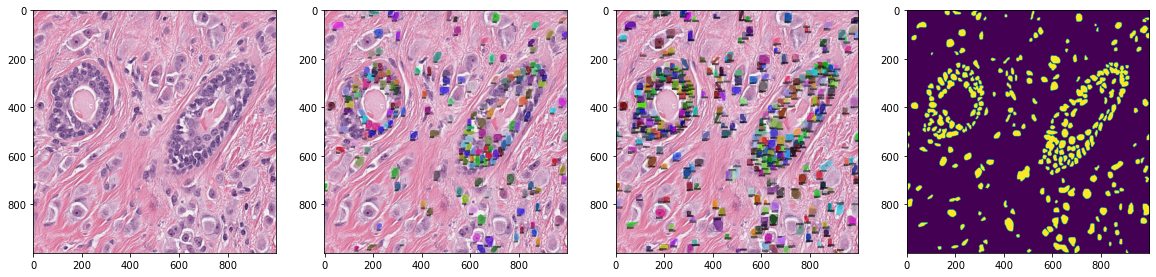

In [104]:
visualize(dataset_dicts=dataset_dicts_nuclei_valid[1:2], 
          metadata=metadata_nuclei_valid,
          ground_truth_available=True,
          with_preds=True,
          predictor=predictor)

## dsb 2018 stage2 test set

### register dataset

In [71]:
DatasetCatalog.clear()

In [72]:
img_paths_test = [path/'images'/f'{path.name}.png' for path in STAGE2_TEST.ls()];len(img_paths_test)
DatasetCatalog.register(dataset_name_test, lambda : get_nuclei_dicts(img_paths_test, isTestSet=True))
MetadataCatalog.get(dataset_name_test).set(thing_classes=["nucleus"])
cfg.DATASETS.TEST = (dataset_name_test, )
predictor = DefaultPredictor(cfg)

### load dataset

In [ ]:
metadata_nuclei_test = MetadataCatalog.get(dataset_name_test)
dataset_dicts_nuclei_test = get_nuclei_dicts(img_paths_test, isTestSet=True)

### visualization

In [ ]:
visualize(dataset_dicts=dataset_dicts_nuclei_test[:2], 
          metadata=metadata_nuclei_test,
          ground_truth_available=False,
          with_preds=True,
          predictor=predictor)

### get predictions

In [ ]:
preds = {}
for d['file_name'] in tqdm(dataset_dicts_nuclei_test):
    p = d['file_name']
    img = cv2.imread(str(p))
    with torch.no_grad():
        pred = predictor(img)
    preds[p.stem] = (pred["instances"].to("cpu"))
    del pred
    torch.cuda.empty_cache()

### create submission

In [ ]:
df_sub = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])

In [ ]:
for i, pred in tqdm(list(preds.items())[:]):
    masks = pred.get('pred_masks')
    if len(masks) == 0:
        df_sub = df_sub.append({'ImageId': i, 'EncodedPixels': ''}, ignore_index=True)
    else:
        ###
        # the competition evaluation at kaggle throws an error, if an encoded pixel belongs to more than one object
        ###
        mask_merged = None
        for mask in masks:
            mask = mask.int()
            if mask_merged == None:
                mask_merged = mask
            else:
                overlap = (mask == mask_merged).int()
                mask = mask - overlap
                mask_merged = merge_masks([mask_merged, mask], shape=(mask.shape[0],mask.shape[1]))
            df_sub = df_sub.append({'ImageId': i, 'EncodedPixels': rle_from_list_to_string(rle_encode(mask))}, ignore_index=True)

In [ ]:
df_sub

In [ ]:
submission_path = Path('./submission_detectron2_2.csv')

In [ ]:
df_sub.to_csv(submission_path, index=False)

In [ ]:
pd.read_csv(submission_path)

## Muscles 

In [3]:
MUSCLES = Path('/home/Deep_Learner/private/datasets/Muskeln')
MUSCLES_WSIS = MUSCLES/'wsis'
MUSCLES_ROIS = MUSCLES/'rois'
MUSCLES_TILES = MUSCLES/'tiles'
dataset_name_muscle = 'nuclei_muscle'

In [ ]:
def open_image_from_wsi(fn:str,
                        tiles_df:pd.DataFrame,
                      convert_mode:str='RGB')->PIL.Image:
        "Open image in `fn`."
        fn = Path(fn)
        tile_name = fn.name
        row = tiles_df.loc[tile_name, : ]
        wsi_path = row['wsi_path']
        x = row['x_upper_left']
        y = row['y_upper_left']
        width = row['pixels_width']
        height = row['pixels_height']
        level = row['level']
        tile = tiles.ExtractTileFromWSI(path=wsi_path, x=x, y=y, width=width, height=height, level=level)
        tile = tile.convert(convert_mode)
        #tile = fastai.vision.image.pil2tensor(tile,np.float32)
        return tile

### Extract tiles

In [4]:
def naming_func_muscles(wsi_path:pathlib.Path):
    path = Path(wsi_path)
    split = path.stem.split('-')
    return f'{split[0]}'[:-1]

### against DecompressionBombWarning
from PIL import Image
Image.MAX_IMAGE_PIXELS = 115990855680000 


df_muscle_tiles_path = Path('./df_muscle_tiles.csv')


if os.path.isfile(df_muscle_tiles_path):
    ###
    # just load from disc, if you have already calculated tile infos before
    ###
    df_muscle_tiles = pd.read_csv(df_muscle_tiles_path).set_index('tile_name')
else:
    ###
    # generate and save tile info
    ###
    df_muscle_tiles = tiles.WsiOrROIToTilesMultithreaded(wsiPaths = MUSCLES_WSIS.ls()[:], 
                                                       tilesFolderPath=None, 
                                                       tileWidth=512, 
                                                       tileHeight=512, 
                                                       tile_naming_func = naming_func_muscles, 
                                                       save_tiles=False,
                                                       tileScoringFunction = tiles.scoring_function_1, 
                                                       is_wsi=False, 
                                                       tile_score_thresh=0.1)
    df_muscle_tiles.to_csv(df_muscle_tiles_path, index_label='tile_name')

In [5]:
len(df_muscle_tiles)

958

In [6]:
df_muscle_tiles.head()

,wsi_path,level,x_upper_left,y_upper_left,pixels_width,pixels_height
tile_name,,,,,,
DKO488_US_wt_10_HE-tile-r15-c8-x3584-y7168-w512-h512.png,/home/Deep_Learner/private/datasets/Muskeln/ws...,0,3584,7168,512,512
DKO488_US_wt_10_HE-tile-r14-c8-x3584-y6656-w512-h512.png,/home/Deep_Learner/private/datasets/Muskeln/ws...,0,3584,6656,512,512
DKO488_US_wt_10_HE-tile-r14-c7-x3072-y6656-w512-h512.png,/home/Deep_Learner/private/datasets/Muskeln/ws...,0,3072,6656,512,512
DKO488_US_wt_10_HE-tile-r15-c7-x3072-y7168-w512-h512.png,/home/Deep_Learner/private/datasets/Muskeln/ws...,0,3072,7168,512,512
DKO488_US_wt_10_HE-tile-r16-c8-x3584-y7680-w512-h512.png,/home/Deep_Learner/private/datasets/Muskeln/ws...,0,3584,7680,512,512


### dataset getter

In [7]:
def get_nuclei_dicts_muscles(img_paths:List[pathlib.Path],
                     extract_otf_from_wsi:bool=False, 
                     df_extraction_otf:pandas.DataFrame=None):
    """
    Arguments:
        dataset_path: List of pathlib.Path to images or if extract_otf_from_wsi the tile names from df_extraction_otf
    """
    dataset_dicts_muscles_json_filepath = Path('./dataset_dicts/dataset_dicts_muscles.json')
    if dataset_dicts_muscles_json_filepath.exists():
        return load_json(dataset_dicts_muscles_json_filepath)
    else:
        dataset_dicts = []
        for path in tqdm(img_paths):
            path = Path(path)
            record = {}
            
            img_pil = None
            if not extract_otf_from_wsi:
                img_pil = PIL.Image.open(path)
            else:
                img_pil =  open_image_from_wsi(path, df_extraction_otf)
                
            width = img_pil.width
            height = img_pil.height
            
            record["file_name"] = str(path)
            record["image_id"] = path.stem
            record["height"] = height
            record["width"] = width
            #no ground truth masks available               
            record["annotations"] = []
            dataset_dicts.append(record)
            
        save_as_json(dataset_dicts, dataset_dicts_muscles_json_filepath)    
        return dataset_dicts

### register dataset

In [8]:
DatasetCatalog.clear()
tile_names_muscles = df_muscle_tiles.index.tolist()
#tile_names_muscles = MUSCLES_TILES.ls()
DatasetCatalog.register(dataset_name_muscle, lambda : get_nuclei_dicts_muscles(tile_names_muscles,  
                                                                               extract_otf_from_wsi=True, 
                                                                                df_extraction_otf=df_muscle_tiles))
MetadataCatalog.get(dataset_name_muscle).set(thing_classes=["nucleus"])

cfg.DATASETS.TEST = (dataset_name_muscle, )
predictor = DefaultPredictor(cfg)

###  load dataset

In [13]:
metadata_nuclei_muscle = MetadataCatalog.get(dataset_name_muscle)
dataset_dicts_nuclei_muscle = get_nuclei_dicts_muscles(random.sample(tile_names_muscles, 5), 
                                                       extract_otf_from_wsi=True, 
                                                       df_extraction_otf=df_muscle_tiles)

### make predictions and visualize them

In [ ]:
visualize(dataset_dicts=dataset_dicts_nuclei_muscle[1:2], 
          metadata=metadata_nuclei_muscle,
          ground_truth_available=False,
          with_preds=True,
          predictor=predictor, 
          extract_otf_from_wsi=True, 
          df_extraction_otf=df_muscle_tiles)

# keep for later use

In [48]:
from fvcore.common.file_io import PathManager
#detectron2.data.detection_utils.read_image
def read_image_custom(file_name, format=None):
    """
    Read an image into the given format.
    Will apply rotation and flipping if the image has such exif information.
    Args:
        file_name (str): image file path
        format (str): one of the supported image modes in PIL, or "BGR"
    Returns:
        image (np.ndarray): an HWC image in the given format.
    """
    image = open_image_custom(file_name)

    # capture and ignore this bug: https://github.com/python-pillow/Pillow/issues/3973
    try:
        image = ImageOps.exif_transpose(image)
    except Exception:
        pass

    if format is not None:
        # PIL only supports RGB, so convert to RGB and flip channels over below
        conversion_format = format
        if format == "BGR":
            conversion_format = "RGB"
        image = image.convert(conversion_format)
    image = np.asarray(image)
    if format == "BGR":
        # flip channels if needed
        image = image[:, :, ::-1]
    # PIL squeezes out the channel dimension for "L", so make it HWC
    if format == "L":
        image = np.expand_dims(image, -1)
    return image




#https://detectron2.readthedocs.io/tutorials/data_loading.html
#https://detectron2.readthedocs.io/_modules/detectron2/data/dataset_mapper.html#DatasetMapper

# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import copy
import logging
import numpy as np
import torch
from fvcore.common.file_io import PathManager
from PIL import Image

from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T

"""
This file contains the default mapping that's applied to "dataset dicts".
"""

__all__ = ["DatasetMapper"]


class DatasetMapper:
    """
    A callable which takes a dataset dict in Detectron2 Dataset format,
    and map it into a format used by the model.

    This is the default callable to be used to map your dataset dict into training data.
    You may need to follow it to implement your own one for customized logic,
    such as a different way to read or transform images.
    See :doc:`/tutorials/data_loading` for details.

    The callable currently does the following:

    1. Read the image from "file_name"
    2. Applies cropping/geometric transforms to the image and annotations
    3. Prepare data and annotations to Tensor and :class:`Instances`
    """

    def __init__(self, cfg, is_train=True):
        if cfg.INPUT.CROP.ENABLED and is_train:
            self.crop_gen = T.RandomCrop(cfg.INPUT.CROP.TYPE, cfg.INPUT.CROP.SIZE)
            logging.getLogger(__name__).info("CropGen used in training: " + str(self.crop_gen))
        else:
            self.crop_gen = None

        self.tfm_gens = utils.build_transform_gen(cfg, is_train)

        # fmt: off
        self.img_format     = cfg.INPUT.FORMAT
        self.mask_on        = cfg.MODEL.MASK_ON
        self.mask_format    = cfg.INPUT.MASK_FORMAT
        self.keypoint_on    = cfg.MODEL.KEYPOINT_ON
        self.load_proposals = cfg.MODEL.LOAD_PROPOSALS
        # fmt: on
        if self.keypoint_on and is_train:
            # Flip only makes sense in training
            self.keypoint_hflip_indices = utils.create_keypoint_hflip_indices(cfg.DATASETS.TRAIN)
        else:
            self.keypoint_hflip_indices = None

        if self.load_proposals:
            self.min_box_side_len = cfg.MODEL.PROPOSAL_GENERATOR.MIN_SIZE
            self.proposal_topk = (
                cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TRAIN
                if is_train
                else cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TEST
            )
        self.is_train = is_train


    def __call__(self, dataset_dict):
        """
        Args:
            dataset_dict (dict): Metadata of one image, in Detectron2 Dataset format.

        Returns:
            dict: a format that builtin models in detectron2 accept
        """
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        # USER: Write your own image loading if it's not from a file
        
        
        image = utils.read_image(dataset_dict["file_name"], format=self.img_format)
        
        
        utils.check_image_size(dataset_dict, image)

        if "annotations" not in dataset_dict:
            image, transforms = T.apply_transform_gens(
                ([self.crop_gen] if self.crop_gen else []) + self.tfm_gens, image
            )
        else:
            # Crop around an instance if there are instances in the image.
            # USER: Remove if you don't use cropping
            if self.crop_gen:
                crop_tfm = utils.gen_crop_transform_with_instance(
                    self.crop_gen.get_crop_size(image.shape[:2]),
                    image.shape[:2],
                    np.random.choice(dataset_dict["annotations"]),
                )
                image = crop_tfm.apply_image(image)
            image, transforms = T.apply_transform_gens(self.tfm_gens, image)
            if self.crop_gen:
                transforms = crop_tfm + transforms

        image_shape = image.shape[:2]  # h, w

        # Pytorch's dataloader is efficient on torch.Tensor due to shared-memory,
        # but not efficient on large generic data structures due to the use of pickle & mp.Queue.
        # Therefore it's important to use torch.Tensor.
        dataset_dict["image"] = torch.as_tensor(np.ascontiguousarray(image.transpose(2, 0, 1)))

        # USER: Remove if you don't use pre-computed proposals.
        if self.load_proposals:
            utils.transform_proposals(
                dataset_dict, image_shape, transforms, self.min_box_side_len, self.proposal_topk
            )

        if not self.is_train:
            # USER: Modify this if you want to keep them for some reason.
            dataset_dict.pop("annotations", None)
            dataset_dict.pop("sem_seg_file_name", None)
            return dataset_dict

        if "annotations" in dataset_dict:
            # USER: Modify this if you want to keep them for some reason.
            for anno in dataset_dict["annotations"]:
                if not self.mask_on:
                    anno.pop("segmentation", None)
                if not self.keypoint_on:
                    anno.pop("keypoints", None)

            # USER: Implement additional transformations if you have other types of data
            annos = [
                utils.transform_instance_annotations(
                    obj, transforms, image_shape, keypoint_hflip_indices=self.keypoint_hflip_indices
                )
                for obj in dataset_dict.pop("annotations")
                if obj.get("iscrowd", 0) == 0
            ]
            instances = utils.annotations_to_instances(
                annos, image_shape, mask_format=self.mask_format
            )
            # Create a tight bounding box from masks, useful when image is cropped
            if self.crop_gen and instances.has("gt_masks"):
                instances.gt_boxes = instances.gt_masks.get_bounding_boxes()
            dataset_dict["instances"] = utils.filter_empty_instances(instances)

        # USER: Remove if you don't do semantic/panoptic segmentation.
        if "sem_seg_file_name" in dataset_dict:
            with PathManager.open(dataset_dict.pop("sem_seg_file_name"), "rb") as f:
                sem_seg_gt = Image.open(f)
                sem_seg_gt = np.asarray(sem_seg_gt, dtype="uint8")
            sem_seg_gt = transforms.apply_segmentation(sem_seg_gt)
            sem_seg_gt = torch.as_tensor(sem_seg_gt.astype("long"))
            dataset_dict["sem_seg"] = sem_seg_gt
        return dataset_dict